# **Caligraphy reader model with skealrn**

# **Data preparation**

In [58]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", as_frame = False)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [59]:
X = mnist.data
y = mnist.target
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [60]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [61]:
print(f'X.shape = {X.shape}')
print(f'y.shape = {y.shape}')

X.shape = (70000, 784)
y.shape = (70000,)


On a 70 000 images dans notre table de données

Nous allons représenter certaines de ces images

In [62]:
import matplotlib.pyplot as plt

def plot_digits(image_data, num_rows=1, num_cols=5):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols, num_rows))
    for i, ax in enumerate(axes.flat):
        ax.imshow(image_data[i].reshape(28, 28), cmap="binary")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

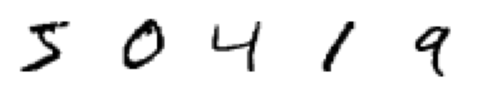

In [63]:
plot_digits(X[:5])

In [64]:
digit=X[0]
for i in range(5):
  print(y[i])

5
0
4
1
9


Les valeurs sont bien celles des images ci-dessus

# **Data Split**

In [65]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000]

# **Binary classifier training**

On simplifie le problème dans un premier temps et on se contente de reconnaitre les '5'

In [66]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [67]:
from sklearn.linear_model import SGDClassifier
binary_classifier = SGDClassifier(random_state=42)
binary_classifier.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

on le test sur X[0] car on sait que c'est un 5

In [68]:
binary_classifier.predict([digit])

array([ True])

Il detecte en effet que c'est un 5

# **Test de performance**

In [69]:
from sklearn.model_selection import cross_val_score

cross_val_score(binary_classifier,  X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Le résultat ici est à nuancé, en effet le score affiche 95% de précision mais en réalité il y a peu de 5 donc lorsque le model ne reconnait pas un 5 il a 90% de chance d'avoir juste. (voir si dessous un le score d'un modèle qui renvooit faux à chaque fois)

In [70]:
from sklearn.dummy  import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)

cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

Traçons d'abord la matrice de confusion : (5 , non 5)

In [71]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_prediction = cross_val_predict(binary_classifier, X_train, y_train_5, cv=3)
cm = confusion_matrix(y_train_5, y_train_prediction)
cm

array([[53892,   687],
       [ 1891,  3530]])

on peut lire la matrice de la façon suivante : 53 892 non 5 on été bien classés et 687 on été considérés comme des 5. En revanche 1891 5 on été considéré comme non 5

# **Définition de la précision**

précision = True positive /(True positive + False Positive)

rappel = True positive /(True Positive + False Ngative)

In [72]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_prediction)

0.8370879772350012

lorsque le modèle affirme reconnaitre un 5, il y a 83,7% de chance d'avoir juste

In [73]:
recall_score(y_train_5, y_train_prediction)

0.6511713705958311

Le modèle détecte que 65.1% des 5

On peut aussi définir le score F1 qui est la moyenne harmonique de la précision et du rappel

F1 = 2/(1/rappel + 1/precision)

In [74]:
from sklearn.metrics import f1_score

f1_score(y_train_5,y_train_prediction)

0.7325171197343846

Le score f1 favorise les classifieur ayant une précision et un rappel proche


or parfois on préfére de pas sélectionner des élements valables pour limiter le risque et donc avoir une précision plus important -> faible rappel et haute précision

On peut aussi préférer un rappel plus haut et une précision plus faible en fonction des cas

In [75]:
y_scores = cross_val_predict(binary_classifier, X_train, y_train_5, cv=3, method="decision_function")

In [98]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, threshold = precision_recall_curve(y_train_5, y_scores)

on trace maintenant les courbes de précision et rappel en fonction du seuil

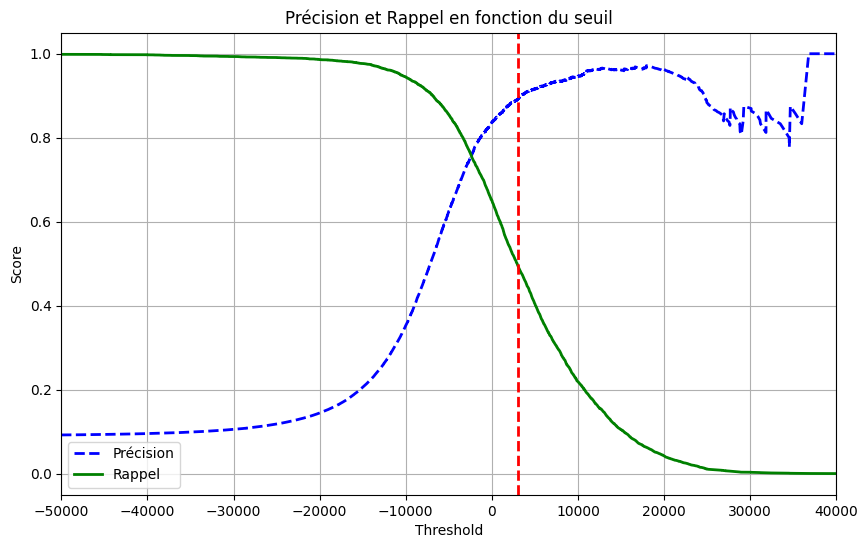

In [110]:
import numpy as np
plt.figure(figsize=(10, 6))
plt.grid(True)

plt.plot(threshold, precisions[:-1], "b--", label="Précision", linewidth=2)
plt.plot(threshold, recalls[:-1], "g-", label="Rappel", linewidth=2)
plt.axvline(x=3000, color='r', linestyle='--', linewidth=2)


plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Précision et Rappel en fonction du seuil')

plt.xlim(-50000, 40000)
plt.legend()

plt.show()

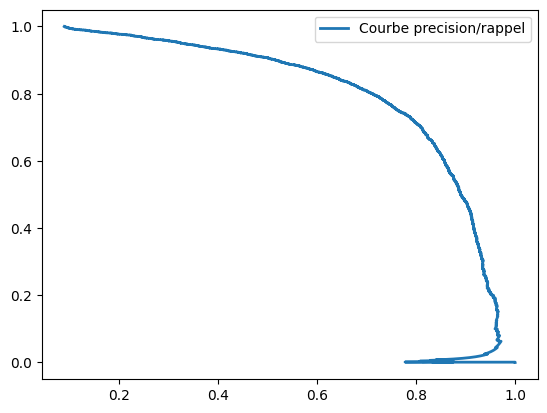

In [101]:
plt.plot(precisions, recalls, linewidth=2, label="Courbe precision/rappel")
plt.legend()
plt.show()